In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import geopandas as gpd
import h3pandas 
sys.path.append('../../../reproducible_figures/scripts/')
import rep_fig_vis as rfv
sys.path.append('../../scripts/')
import create_dataset_utils as cdu
import paired_embeddings_models as pem
sys.path.append('../../../satbird_explore/')
import utils_explore as ue
sys.path.append('../../../cnn-land-cover/scripts/')
import land_cover_analysis as lca 
import land_cover_visualisation as lcv
import shapely
from tqdm import tqdm, tqdm_notebook
import torch

In [3]:
df_mapping_locs, _ = cdu.load_names_unique_locs()
df_mapping_locs.head()

,tuple_coords,footprintWKT,count,name_loc
0,"(-2.165105, 50.956811)","POLYGON((-2.17221 50.9523,-2.17221 50.96132,-2...",53410,UKBMS_loc-0000
1,"(-2.646667, 50.775285)","POLYGON((-2.6537 50.77075,-2.6537 50.77982,-2....",51809,UKBMS_loc-0001
2,"(-0.828484, 50.888106)","POLYGON((-0.8357 50.88368,-0.8357 50.89253,-0....",48596,UKBMS_loc-0002
3,"(-1.966038, 50.59722)","POLYGON((-1.97311 50.59273,-1.97311 50.60171,-...",46522,UKBMS_loc-0003
4,"(-0.22994099999999998, 52.409243)","POLYGON((-0.23747 52.40486,-0.23747 52.41363,-...",44130,UKBMS_loc-0004


In [4]:
df_per_loc = cdu.load_species_dataset()
df_per_loc.head()

,tuple_coords,Melanargia galathea,Pieris napi,Aphantopus hyperantus,Aglais io,Polyommatus icarus,Vanessa atalanta,Lycaena phlaeas,Pararge aegeria,Gonepteryx rhamni,...,Tyria jacobaeae,Euclidia glyphica,Odezia atrata,Melitaea cinxia,Carterocephalus palaemon,Nymphalis polychloros,Nymphalis antiopa,Erebia epiphron,n_visits,name_loc
0,"(-7.824283, 54.259247)",0.0,0.696970,0.242424,0.333333,0.272727,0.060606,0.121212,0.545455,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33,UKBMS_loc-1044
1,"(-7.457325, 54.15933)",0.0,0.419355,0.387097,0.354839,0.000000,0.064516,0.000000,0.870968,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31,UKBMS_loc-1420
2,"(-6.949025, 54.883646)",0.0,0.363636,0.409091,0.045455,0.000000,0.090909,0.000000,0.818182,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22,UKBMS_loc-0979
3,"(-6.753205, 55.169256)",0.0,0.448276,0.413793,0.034483,0.448276,0.034483,0.034483,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29,UKBMS_loc-0925
4,"(-6.405594, 55.228089)",0.0,0.718750,0.187500,0.375000,0.437500,0.093750,0.500000,0.218750,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32,UKBMS_loc-0962


In [27]:
ds = pem.DataSetImagePresence(image_folder='/Users/t.vanderplas/data/UKBMS_sent2_ds/sent2-4band/2019/m-06-09/',
                              presence_csv='/Users/t.vanderplas/data/UKBMS_sent2_ds/bms_presence/bms_presence_y-2018-2019_th-200.csv',
                              species_process='priority_species',
                              zscore_im=False, normalise_image=False,
                              augment_image=False, mode='val')


Found 1336 out of 1455 images in the image folder.
Sorting data by name_loc.
Only keeping 3/62 species that are indicator species.
At least one priority species present in 1335 out of 1336 locations.


In [31]:
for i_sample, sample in tqdm(enumerate(ds)):
    im, target = sample
    if i_sample == 0:
        im_aggr = im[None, ...].clone()
    else:
        im_aggr = torch.cat((im_aggr, im[None, ...]), dim=0)
    # if i_sample == 100:
    #     break 

im_aggr.shape
mean = im_aggr.mean(dim=(0, 2, 3))
std = im_aggr.std(dim=(0, 2, 3))
print(mean, std)

100it [00:06, 16.04it/s]


tensor([ 643.6945,  754.1613,  497.1894, 3370.9927]) tensor([ 521.2877,  423.2568,  436.1025, 1024.3015])


In [18]:
# import seaborn as sns

# fig, ax = plt.subplots(1, 3, figsize=(10, 3))

# import itertools
# for i, (species1, species2) in enumerate(itertools.combinations(ds.species_list, 2)):
#     sns.jointplot(data=ds.df_presence, x=species1, y=species2, ax=ax[i])
#     ax[i].set_title(f'{species1} vs {species2}')


In [31]:
tmp = 1 / (ds.df_presence[ds.species_list].sum(0) / ds.df_presence[ds.species_list].sum().sum())
# np.percentile(tmp, 75)
tmp = np.clip(tmp, np.percentile(tmp, 25), np.percentile(tmp, 75))
tmp = tmp / tmp.min()
tmp.index == ds.species_list

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

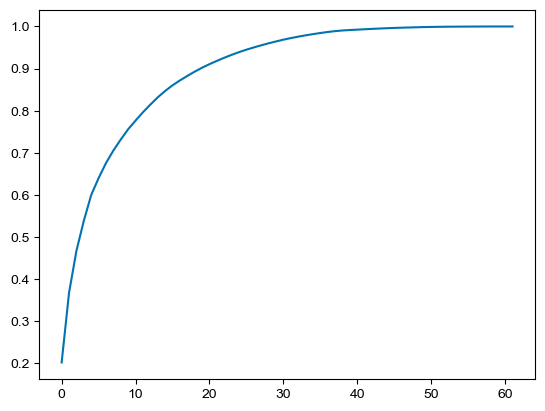

In [59]:
pres_val = ds.df_presence[ds.species_list].values
from sklearn.decomposition import PCA 
pca = PCA()
pca.fit(pres_val)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [65]:
# path_ex_im_satbird = '/Users/t.vanderplas/data/satbird/Kenya/images_visual/L1197337_visual.tif'
# path_ex_im_satbird = '/Users/t.vanderplas/data/satbird/Kenya/images_visual/L1219423_visual.tif'  # black 
path_ex_im_bms = '/Users/t.vanderplas/data/UKBMS_sent2_ds/sent2-4band/2019/m-06-09/sent2-4band_UKBMS_loc-0000_y-2019_m-06-09.tif'
im = pem.load_tiff(path_ex_im_bms)
im.max(), im.shape

(6352, (4, 256, 256))

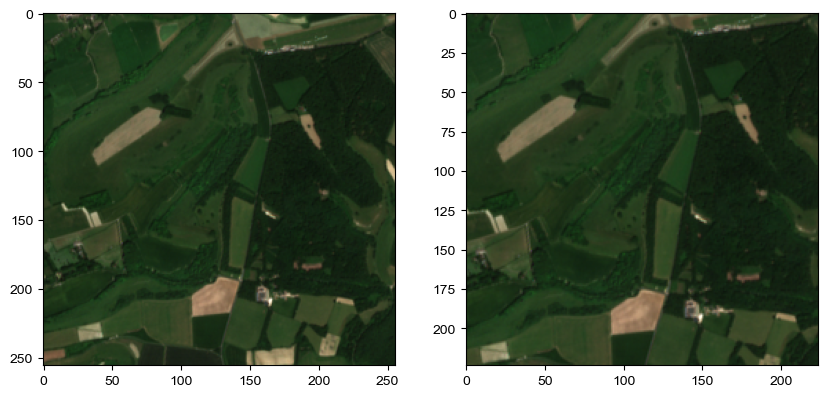

In [17]:
im, pres = ds[0]
im_transformed = ds.transform_data(im)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(im[:3, :, :].permute(1, 2, 0))
ax[1].imshow(im_transformed[:3, :, :].permute(1, 2, 0))

In [78]:
im_enc = pem.ImageEncoder(n_species=ds.n_species, n_bands=4, freeze_resnet=True,
                          class_weights=ds.weights_values)

Loaded 3 class weights on cpu.
Class weights on mps:0.


/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Results 

- v16 pred / n layers 1 
- v17 pred incl enc / n layers 2 
- v18 pecl / n layers 1 
- v19 post-pecl pred / n layers 1
- v20: pred incl enc / n_layers 2 / freeze True 
- v21: pred / n layers 2 / freeze True 
- v22: pred incl enc / n layers 2 / freeze False 

Findings:
- PECL doesn't work atm (v19 v20). Why does post-pecl pred not work though (V20)? Does passing on models in general work?
- Freezing resnet doesn't matter for pred_incl_enc (v20 v22)
- Pred incl enc works better than pred only (v22 vs v21, v17 vs v16)
- All same plateau .. Check for a trivial solution? (Different random seed.. )

In [129]:
# dict_models = {}
tmp_model, _ = pem.train_pecl(training_method='pred_incl_enc', 
                    pecl_distance_metric='softmax',
                    species_process='priority_species', zscore_im=True,
                    use_class_weights=True,
                    n_enc_channels=128, lr=1e-4,
                    n_epochs_max=100, batch_size=64, 
                    pecl_knn=10, 
                    freeze_resnet=False, n_layers_mlp=1,
                    pred_train_loss='weighted-bce',
                    normalise_embedding='l2')
# dict_models['bce_top20_cw'] = tmp_model

   

Seed set to 42
/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Pytorch version is 2.2.0.dev20231210
Found 1336 out of 1455 images in the image folder.
Shuffling data.
Only keeping 3/62 species that are indicator species.
At least one priority species present in 1335 out of 1336 locations.
Loaded 3 class weights on cpu.
Class weights on mps:0.


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type       | Params
------------------------------------------------
0 | resnet           | ResNet     | 11.2 M
1 | prediction_model | Sequential | 387   
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.983    Total estimated model params size (MB)


-- Starting training at 2024-02-19 18:32:02.561798 with 100 epochs.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


-- Finished training at 2024-02-19 19:09:15.333980.


In [154]:
tmp_model = pem.ImageEncoder(n_species=ds.n_species, n_bands=4, freeze_resnet=True,
                             pecl_distance_metric='softmax',
                             training_method='pecl')

No class weights.


/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [174]:
# tmp = tmp_model.pecl_pass(batch)
# tmp[0], tmp[1].shape    

# (pem.normalised_softmax_distance_batch(im_enc) > 0).all()

tensor(True)

In [42]:
# train_dl, val_dl = _
# tmp_model = dict_models['pred_incl_enc']
# val_dl = torch.utils.data.DataLoader(ds, batch_size=8, shuffle=True)


for i_batch, batch in enumerate(val_dl):
    im, label = batch 
    print(im.shape[0])
    im_enc = tmp_model.forward(im)
    pred = tmp_model.prediction_model(im_enc)
    assert pred.shape == label.shape, f'pred.shape={pred.shape}, label.shape={label.shape}'
    if i_batch == 1:
        break

32
32


In [27]:
ind = 4
label[ind], pred[ind]

(tensor([0.5208, 0.2500, 0.0417]),
 tensor([0.5655, 0.4683, 0.2811], grad_fn=<SelectBackward0>))

In [34]:
label.mean(0) - pred.mean(0)

array([ 0.041031  , -0.01940268, -0.02952704], dtype=float32)

(32, 3)


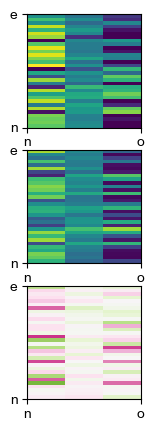

In [43]:
if type(pred) == torch.Tensor:
    pred = pred.detach().numpy()
if type(label) == torch.Tensor:
    label = label.detach().numpy()
pred_zero_mean = pred - pred.mean(0)
label_zero_mean = label - label.mean(0)
assert pred.max() <= 1, f'pred.max()={pred.max()}'
assert pred.min() >= 0, f'pred.min()={pred.min()}'
assert label.max() <= 1, f'label.max()={label.max()}'
assert label.min() >= 0, f'label.min()={label.min()}'

print(label.shape)
fig, ax = plt.subplots(3, 1, figsize=(10, 5))
ax[0].imshow(label, vmin=0, vmax=1, cmap='viridis', extent='none')
ax[1].imshow(pred, vmin=-0, vmax=1, cmap='viridis', extent='none')
ax[2].imshow(pred - label, vmin=-1, vmax=1, cmap='PiYG', extent='none')

Text(0, 0.5, 'Predicted label')

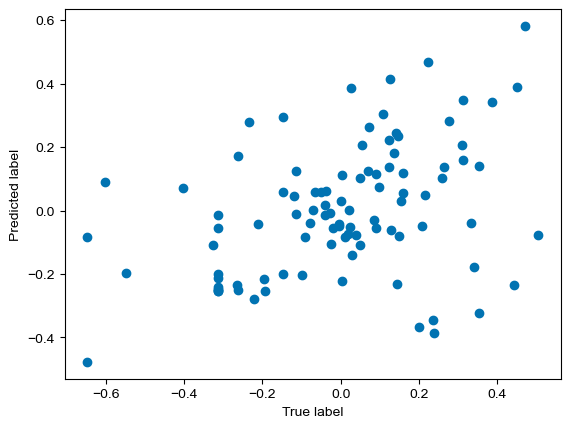

In [44]:
i_sample = 0
plt.scatter(label_zero_mean[:, :].ravel(), pred_zero_mean[:, :].ravel())
plt.xlabel('True label')
plt.ylabel('Predicted label')

In [84]:
# dict_models['pred']

In [127]:
# tmp_model = dict_models['pred_pca']
# tmp_model = im_enc
# tmp_model = pem.ImageEncoder.load_from_checkpoint("/Users/t.vanderplas/models/PECL/lightning_logs/version_2/checkpoints/best_checkpoint_val-epoch=45-val_loss=0.28-train_loss=0.15.ckpt")
# print(model.learning_rate)
tmp_model.eval()
single_data_sample = ds[0][0]
multi_data_sample = [ds[ii][0] for ii in range(10)]
multi_data_sample = torch.stack(multi_data_sample)
multi_label_sample = torch.stack([ds[ii][1] for ii in range(10)])
pred_enc = tmp_model.forward(multi_data_sample)
pred_pres = tmp_model.prediction_model(pred_enc)

print(pred_enc.shape, pred_pres.shape, multi_label_sample.shape)
tmp_model.top_k_accuracy(preds=pred_pres, target=multi_label_sample, k=20)

torch.Size([10, 32]) torch.Size([10, 20]) torch.Size([10, 20])


tensor(1.)

torch.Size([10, 32])


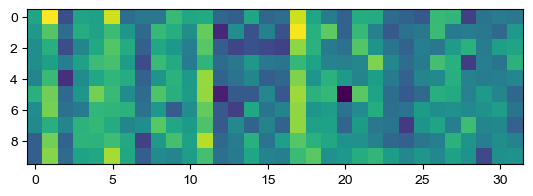

In [128]:
tmp_pred = tmp_model.resnet(multi_data_sample)
print(tmp_pred.shape)
plt.imshow(tmp_pred.detach().numpy())
# torch.nn.functional.normalize(tmp_pred, p=1, dim=1).abs().sum(1)

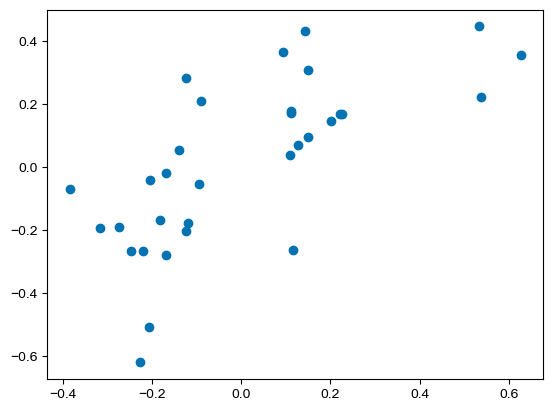

In [129]:
plt.scatter(tmp_pred[0, :].detach().numpy(), tmp_pred[5, :].detach().numpy())

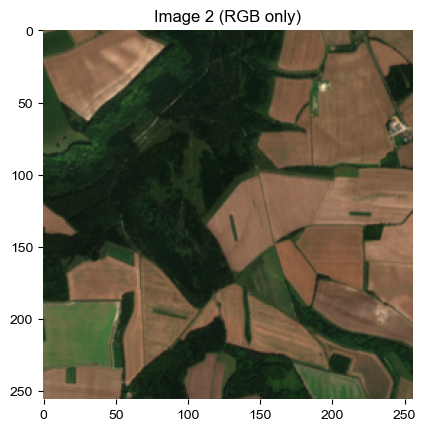

In [91]:
ds.plot_image(2)

In [46]:

target = torch.tensor([[.3, .1, .2, .1],[.1, 1, .3, .5]])
preds = torch.tensor([[0.1, 0.9, 0, 0], [0.2, 0.1, 0.5, 0.2]])
assert preds.shape[0] == target.shape[0], f'preds.shape[0] = {preds.shape[0]} != target.shape[0] = {target.shape[0]}'

loss_fn = torch.nn.BCELoss(reduction='none')
intermediate_loss = loss_fn(preds, target)
weights = torch.tensor([3.1, .2, 1.3, .4])
# print(intermediate_loss)
print(intermediate_loss)
final_loss = (intermediate_loss * weights)
final_loss.mean()

tensor([[ 0.7645,  2.0829, 20.0000, 10.0000],
        [ 0.3618,  2.3026,  0.6931,  0.9163]])


tensor(4.4545)

In [138]:
import segmentation_models_pytorch as smp
for model_name in ['resnet18', 'resnet34', 'resnet50']:
    tmp = smp.encoders.get_preprocessing_fn(model_name, pretrained='imagenet')
    print(tmp.keywords['mean'], tmp.keywords['std'])

[0.485, 0.456, 0.406] [0.229, 0.224, 0.225]
[0.485, 0.456, 0.406] [0.229, 0.224, 0.225]
[0.485, 0.456, 0.406] [0.229, 0.224, 0.225]


## To try:
- normalise image encoding (L2 normalise?)
- Use different distance; something like that distr from SCE?
- But first, implement prediction task to gauge performance (accuracy, top-k accuracy etc)

### Different distance:
SupCon paper:

Normally for CL, if `z = MLP ( ENC (x))`, and sample `i` has one positive sample `j`, the loss function is:

$L_{CL} = - \sum_i \log \frac{\exp (z_i \cdot z_j(i) / \tau)}{\sum_{k \neq i} \exp (z_i \cdot z_k / \tau)} $

The intuition being that for positive pairs, any distance between them is loss. This is soft-maxed for whatever reason. (Not sure why positive pair is excluded from denominator..) 

For SupCon, they develop an equivalent for more than 1 positive pairs:

$ L_{SupCon} = \sum_i \frac{-1}{| P(i) |} \sum_{p \in P} \log \frac{\exp (z_i \cdot z_p(i) / \tau)}{\sum_{k \neq i} \exp (z_i \cdot z_k / \tau)} $

For my idea, where `s` is the species representation, maybe:

$ d_{ij}^z = - \log \frac{\exp (z_i \cdot z_j / \tau)}{\sum_{k \neq i} \exp (z_i \cdot z_k / \tau)} $

$ d_{ij}^s = - \log \frac{\exp (s_i \cdot s_j / \tau)}{\sum_{k \neq i} \exp (s_i \cdot s_k / \tau)} $

Or should the normalisation in denominator be for all pairs $\sum_{i, j}$ instead of only pairs with $i$ ($\sum_j$) ..? Every distance will be very small I presume (dominated by a few ones.).

$ L_{PECL} = \sum_i \sum_{j > i} l(d_ij^z - d_ij^s) $ with $l = l_1, l_2, ..$

Where this is done per batch -- as also done in SupCon paper I understand, so $N$ is batch size. 

In [3]:
n_samples = 6
n_classes = 5
## create two random torch matrices
# matrix 1
matrix1 = np.random.rand(n_samples, n_classes)
# matrix 2
matrix2 = np.random.rand(n_samples, n_classes)
matrix1 = torch.tensor(matrix1).float()
matrix2 = torch.tensor(matrix2).float()
assert matrix1.ndim == 2
tmp = torch.mm(matrix1, matrix1.t())

print(tmp.sum(0), tmp.sum(1))

tensor([5.9671, 7.0691, 7.5548, 8.7021, 6.4149, 2.7796]) tensor([5.9671, 7.0691, 7.5548, 8.7021, 6.4149, 2.7796])


In [144]:
dist1 = pem.normalised_softmax_distance_batch(matrix1, exclude_diag_in_denominator=False, flatten=True)
dist2 = pem.normalised_softmax_distance_batch(matrix2, exclude_diag_in_denominator=False, flatten=True)

torch.Size([2, 15]) torch.Size([6, 6])
torch.Size([2, 15]) torch.Size([6, 6])
